# I. Algorithm

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [65]:
import numpy as np

class Neural_Networks:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        layer_sizes: list of sizes like [input_size, h1, h2, ..., output_size]
        """
        self.lr = learning_rate
        self.num_layers = len(layer_sizes) - 1
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(self.num_layers):
            # in_size gives number of inputs at layer_i, out_size gives number of outputs after layer_i
            in_size = layer_sizes[i]
            out_size = layer_sizes[i+1]
            # Initialize weights according to the Kaiming He initialization rule
            self.weights.append(np.random.randn(in_size, out_size) * np.sqrt(2. / in_size))
            self.biases.append(np.zeros((1, out_size)))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
       
    def forward(self, X):
        self.zs = []
        self.activations = [X]
        a = X
        for i in range(self.num_layers - 1):  # Hidden layers
            z = a @ self.weights[i] + self.biases[i]
            a = self.sigmoid(z)
            self.zs.append(z)
            self.activations.append(a)
        # Output layer (with sigmoid)
        z = a @ self.weights[-1] + self.biases[-1]
        a = self.sigmoid(z)
        self.zs.append(z)
        self.activations.append(a)
        return a  # output with sigmoid activation

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads_w = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        
        # Output layer gradients (MSE loss)
        delta = (y_pred - y_true) / m
        grads_w[-1] = self.activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # Hidden layers (backpropagation)
        for i in reversed(range(self.num_layers - 1)):
            delta = (delta @ self.weights[i+1].T) * self.sigmoid_deriv(self.zs[i])
            grads_w[i] = self.activations[i].T @ delta
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases
        for i in range(self.num_layers):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train(self, X, y, epochs=1000, verbose=True):
        errors = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = np.mean((y - y_pred) ** 2)
            self.backward(y, y_pred)
            if verbose and epoch % 80 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
            errors.append(loss)
        return errors
            
    def predict(self, X):
        return self.forward(X)


# II. Application to Data Set

In [20]:
# Loading in Data Set and Cleaning
game_data = pd.read_csv("../bgg_dataset.csv",delimiter=";")

game_data['Complexity Average'] = game_data['Complexity Average'].str.replace(',', '.').astype(float)
game_data['Rating Average'] = game_data['Rating Average'].str.replace(',', '.').astype(float)

# Selecting Columns of Top 100 Games
game_cleaned = game_data[['Rating Average','Complexity Average','Min Age','Play Time','BGG Rank']]
game_cleaned = game_cleaned[game_cleaned['BGG Rank'] <= 100]
game_cleaned.dropna(inplace = True)

# Labelling short games as those where play time is less than or equal to 60 minutes
game_cleaned['short'] = np.where(game_cleaned['Play Time'] <= 60, 1, 0)

short = game_cleaned[game_cleaned['short'] == 1]
long = game_cleaned[game_cleaned['short'] == -1]

We will use ```'Rating Average'```, ```'Complexity Average'```, and ```'Min Age'``` to predict whether the game is short or long.

In [68]:
# Preparing data 
X = game_cleaned[['Rating Average', 'Complexity Average','Min Age']].to_numpy()
y = game_cleaned['short'].to_numpy()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#Scale the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define and fit the neural network
model = Neural_Networks(layer_sizes = [3, 10, 1])
model_errors = model.train(X_train_scaled, y_train.reshape(-1,1))

# 4. Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_labels = (y_pred >= 0.5).astype(int)
print(f"Accuracy:{accuracy_score(y_test, y_pred_labels)}")
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


Epoch 0, Loss: 0.4039
Epoch 80, Loss: 0.2430
Epoch 160, Loss: 0.1871
Epoch 240, Loss: 0.1664
Epoch 320, Loss: 0.1564
Epoch 400, Loss: 0.1501
Epoch 480, Loss: 0.1453
Epoch 560, Loss: 0.1413
Epoch 640, Loss: 0.1377
Epoch 720, Loss: 0.1344
Epoch 800, Loss: 0.1314
Epoch 880, Loss: 0.1286
Epoch 960, Loss: 0.1259
Accuracy:0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.00      0.00      0.00         4

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20



/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

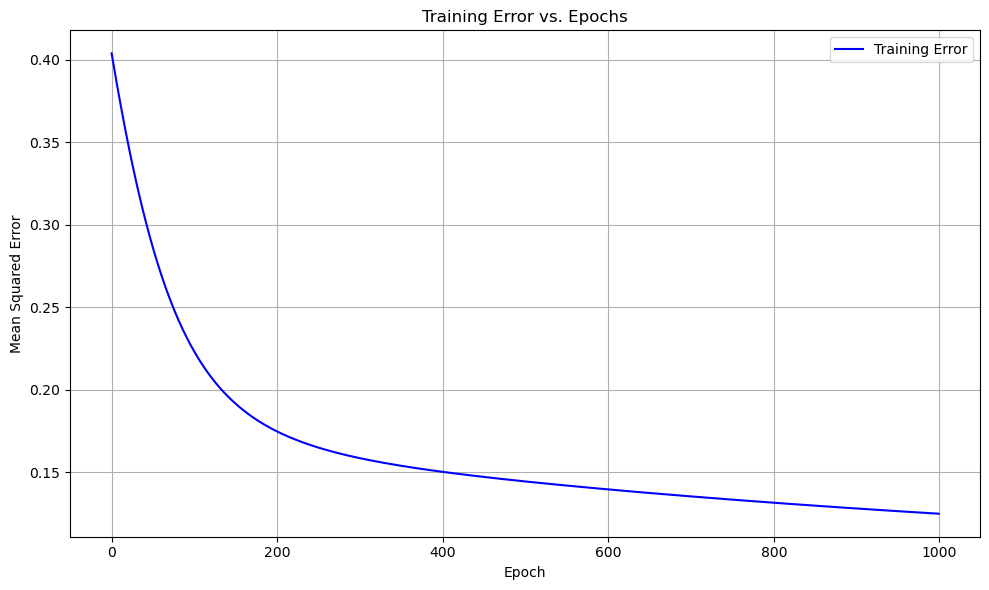

In [69]:
# Plotting training error vs. epochs
epochs = np.arange(len(model_errors))  
plt.figure(figsize=(10, 6))
plt.plot(epochs, model_errors, label='Training Error', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Error vs. Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()